# Constructing Unbiased Estimates for Missing Data Values

This notebook illustrates how **FRANKEN-Z** deals with missing data. Since most training sets/testing sets contain some amount of missing data, developing a way to properly exploit these incomplete data is crucial for maximizing our output information content.

We first demonstrate how a (very sophisticated) "out of the box" solver [**FancyImpute**](https://github.com/hammerlab/fancyimpute) deals with this issue, and some of its drawbacks. We then outline a (novel?) approach we term **WINBET**, which tries to do better by incorporating some basic population information along with measurement error into the missing data predictions. Finally, we demonstrate how **FRANKEN-Z** uses **WINBET** in practice to properly model possibly strong covariances present when inferring missing galaxy fluxes.

Note that this code requires **FancyImpute** and relevant dependencies for the initial data imputation demonstration.

## Setup

We first set up the environment.

In [33]:
import sys # system commands
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d # interpolation
from scipy import stats # statistics functions
from scipy import special # special functions

# FancyImpute
import fancyimpute

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Let's again import our mock data and templates.

In [2]:
# load observed data
data=load('mock_catalog_hsc-cosmos.npy')
phot_d=data[:,[0,1,2,3,4]] # fluxes
err_d=data[:,[5,6,7,8,9]] # flux errors
var_d=square(err_d) # flux variances
mask_d=(err_d>0.) # mask for missing data
redshift_d=data[:,10] # redshifts
types_d=data[:,11].astype(int) # types
Nobs=len(data) # number of objects

Nclass=(8,11,12) # passive, spiral, and starburst galaxies, respectively
maglims=[26.5,26.1,25.9,25.1,24.4] # g,r,i,z,y 5-sigma limits for HSC data

Nf=len(phot_d[0]) # number of filters
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(sqrt(var_d),axis=0)
mag_d,magerr_d=fz.asinh_mag_map(phot_d,err_d,skynoise,zeropoint=flux_zeropoint) # Luptitude mapping

# load model data
models=load('model_catalog_hsc-cosmos.npy')
phot_m=models[:,[0,1,2,3,4]] # fluxes
err_m=zeros(phot_m.shape) # flux errors
var_m=square(err_m) # flux variances
mask_m=ones(phot_m.shape).astype(bool) # mask for missing data
redshift_m=models[:,-2] # redshifts
types_m=models[:,-1].astype(int) # types
Nmodels=len(models) # number of objects

# template grid
Ut,t_inv=unique(types_m,return_inverse=True) # order unique types
Nt=len(Ut) # number of unique types

# redshift grid
Uz,z_inv=unique(redshift_m,return_inverse=True) # ordered unique redshifts
Nz=len(Uz) # number of unique redshifts
dz=Uz[1]-Uz[0]

# discretize redshifts
zidx_m=((redshift_m-Uz[0])/(Uz[1]-Uz[0])).round().astype(int)

Now let's set up FRANKEN-Z.

In [3]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# discretize data
lzidx_d,lzeidx_d=rdict.fit(log(1+redshift_d),ones(Nobs)*rdict.dlz)
lzidx_m,lzeidx_m=rdict.fit(log(1+redshift_m),ones(Nmodels)*rdict.dlz)

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color
midx_d,meidx_d=mdict.fit(mag_d,magerr_d)

Let's again apply a basic selection function.

In [4]:
sel=(mag_d[:,2]<maglims[2]) # applying i-band cut
Nsel = sel.sum() # number of galaxies post-cut
print 'Number of observed galaxies (all):',Nobs
print 'Number of observed galaxies (selected):',Nsel
print 'Number of models:',Nmodels

Number of observed galaxies (all): 500000
Number of observed galaxies (selected): 181162
Number of models: 18631


We again split the data into a training and testing set.

In [5]:
# select training/testing samples
ftrain=0.4 # fraction of sample available for training
Ntrain=int(Nsel*ftrain) # number of training objects
Ntest=Nsel-Ntrain
train_sel=zeros(Nsel).astype(bool)
train_sel[choice(Nsel,size=Ntrain,replace=False)]=True # training selection flag
test_sel=(train_sel==False) # testing selection flag

# define training/testing data
phot_train_d,var_train_d,mask_train_d=phot_d[sel][train_sel],var_d[sel][train_sel],mask_d[sel][train_sel] 
phot_test_d,var_test_d,mask_test_d=phot_d[sel][test_sel],var_d[sel][test_sel],mask_d[sel][test_sel]
redshift_train_d,lzidx_train_d,lzeidx_train_d=redshift_d[sel][train_sel],lzidx_d[sel][train_sel],lzeidx_d[sel][train_sel]
redshift_test_d,lzidx_test_d,lzeidx_test_d=redshift_d[sel][test_sel],lzidx_d[sel][test_sel],lzeidx_d[sel][test_sel]

mag_train_d,magerr_train_d=mag_d[sel][train_sel],magerr_d[sel][train_sel] # training mags
mag_test_d,magerr_test_d=mag_d[sel][test_sel],magerr_d[sel][test_sel] # testing mags

print 'Number of training objects:',Ntrain
print 'Number of testing objects:',Ntest

Number of training objects: 72464
Number of testing objects: 108698


We now want to simulate censorship. Let's just imagine that 1/100 objects is missing a band, censored randomly. This could be the case where 99% of a survey has coverage in each band, where the missing 1% of area differs per filter.

In [26]:
# censor data
mask_d[sel]=(random.uniform(size=(phot_d[sel]).shape)>0.01) # randomly censor objects
mask_d[sel,2]=True # all i-band magnitudes remain uncensored because that's how objects were selected
mask_train_d,mask_test_d=mask_d[sel][train_sel],mask_d[sel][test_sel]
csel=(mask_d[sel].sum(axis=1)<5)

print 'Number of censored training objects:',(mask_train_d.sum(axis=1)<5).sum()
print 'Number of censored testing objects:',(mask_test_d.sum(axis=1)<5).sum()

Number of censored training objects: 2870
Number of censored testing objects: 4261


## FancyImpute

First, let's try and take advantage of an "out of the box" solver to show how difficult the problem can be, especially in the presence of measurement error and heavily skewed (power-law!) distributions. If we think of our dataset not as a series of $N_{\textrm{obj}}$ features with dimensionality $N_{\textrm{filter}}$, but rather as a $N_{\textrm{obj}} \times N_{\textrm{filter}}$ **data matrix** with randomly censored entries, there's some very nice work about how to solve this problem available in the literature. Conveniently, several as also implemented in Python through the package **FancyImpute**.

We first want to check if we can impute missing data without bias. Initial tests showed that the **MICE** method (Multiple Imputation by Chained Equations) works reasonably well with magnitude data and is quite robust to starting conditions. Using Monte Carlo methods, we can then generate a set of imputed magnitudes via MICE, which we then use to derive mean quantities and associated errors.

In [7]:
N_mc=100
mag_d_impute=empty((N_mc,sum(csel),Nf)) # imputed magnitude array

for i in xrange(N_mc):
    sys.stdout.write(str(i)+' ')
    # censored data matrix
    mag_d_censor=normal(mag_d,magerr_d) # jitter data
    mag_d_censor[mask_d==False]=nan # censor data
    
    # impute missing magnitudes
    mag_d_impute[i]=fancyimpute.MICE(verbose=False,n_burn_in=10,n_imputations=10).complete(mag_d_censor[sel])[csel]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [8]:
mag_d_impute_mean=mag_d_impute.mean(axis=0) # mean
magerr_d_impute=mag_d_impute.std(axis=0) # err
mdev=(mag_d_impute_mean-mag_d[sel][csel])[mask_d[sel][csel]==False] # deviation
mdev_mc=normal(zeros(len(mdev)),magerr_d[sel][mask_d[sel]==False]) # monte carlo
mdev_norm=mdev/sqrt(magerr_d_impute**2+magerr_d[sel][csel]**2)[mask_d[sel][csel]==False] # normalized deviation (impute)
mdev_mc_norm=mdev_mc/magerr_d[sel][mask_d[sel]==False] # normalized deviation (MC)

Now let's examine the results.

Mean offset (imputed): -0.00220961221267
Mean offset (Monte Carlo): -0.00257682120539


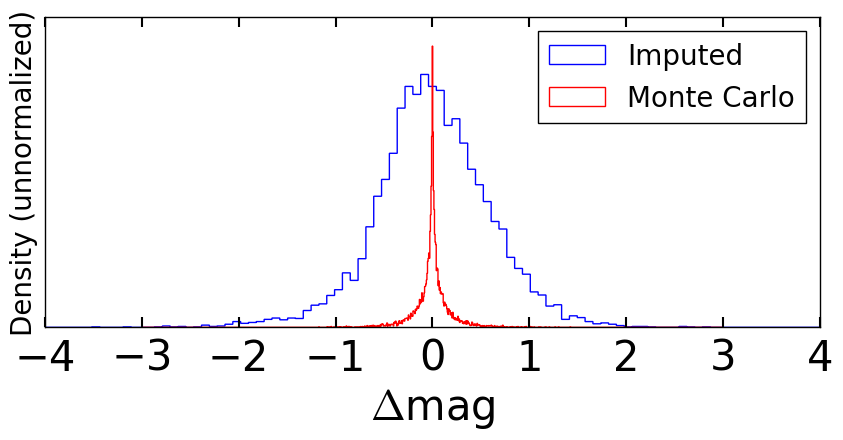

In [9]:
# plot mean deviation
figure(figsize=(10,4))
h=hist(mdev,histtype='step',bins=linspace(-4,4,100),color='blue',label='Imputed')
h=hist(mdev_mc,histtype='step',bins=linspace(-3,3,1000),color='red',label='Monte Carlo')
legend(fontsize=20)
xlabel('$\Delta$mag')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Mean offset (imputed):',mean(mdev)
print 'Mean offset (Monte Carlo):',mean(mdev_mc)

The distribution of imputed magnitude deviations over the population is unbiased, but significantly broader than what you'd expect just from measurement error. This makes some intuitive sense: we're trying to infer the magnitude without actually having measured it using "similar" objects in the presence of errors, and there's only so far we can go with that.

The real question of course is the true source of the broadening. In the best case, it is due to small biases but large variation among individual objects, whereas in the worst case there are only small variations in imputed magnitudes but large biases from object to object.

Median normalized offset (imputed): -0.0493543309814
Median normalized offset (Monte Carlo): -0.00956817271924


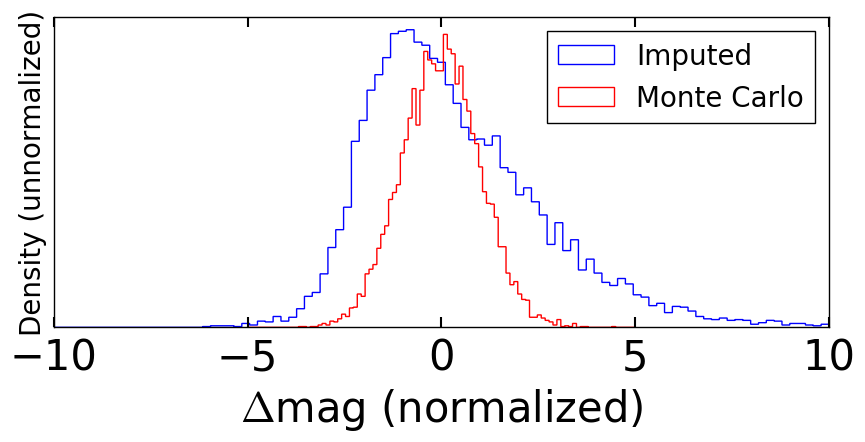

In [10]:
# plot mean normalized deviation
figure(figsize=(10,4))
h=hist(mdev_norm,histtype='step',bins=linspace(-10,10,100),color='blue',label='Imputed')
h=hist(mdev_mc_norm,histtype='step',bins=linspace(-5,5,100),color='red',label='Monte Carlo')
legend(fontsize=20)
xlabel('$\Delta$mag (normalized)')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median normalized offset (imputed):',median(mdev_norm)
print 'Median normalized offset (Monte Carlo):',median(mdev_mc_norm)

For better or for worse, it looks like we're somewhere in-between: imputed magnitudes are biased, but the errors are significantly inflated to somewhat counteract this. The distribution is also markedly assymetric, with a long tail towards over-estimation compared with underestimation. The nature of this bias is shown below.

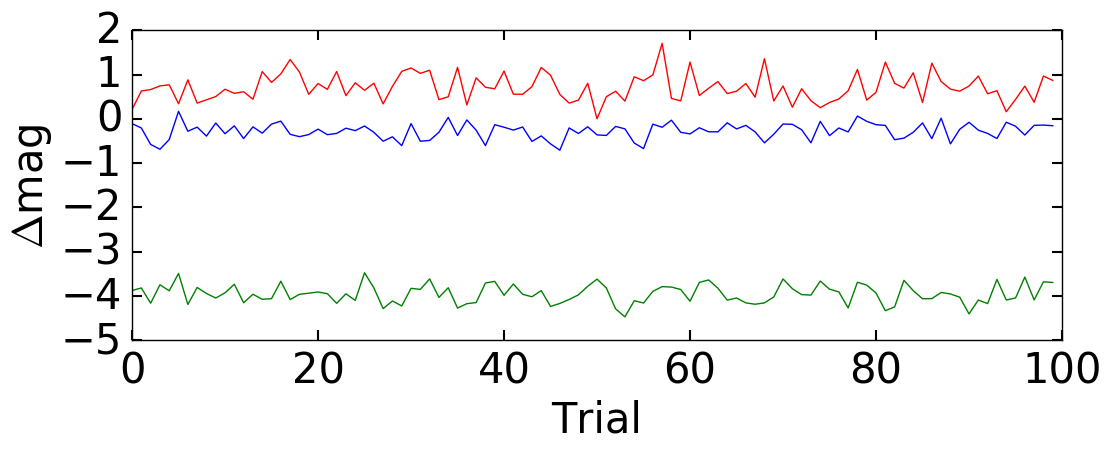

In [11]:
figure(figsize=(12,4))
plot(mag_d_impute[:,mask_d[sel][csel]==False][:,8]-mag_d[sel][csel][mask_d[sel][csel]==False][8])
plot(mag_d_impute[:,mask_d[sel][csel]==False][:,2]-mag_d[sel][csel][mask_d[sel][csel]==False][8])
plot(mag_d_impute[:,mask_d[sel][csel]==False][:,17]-mag_d[sel][csel][mask_d[sel][csel]==False][8])
xlabel('Trial')
ylabel('$\Delta$mag')

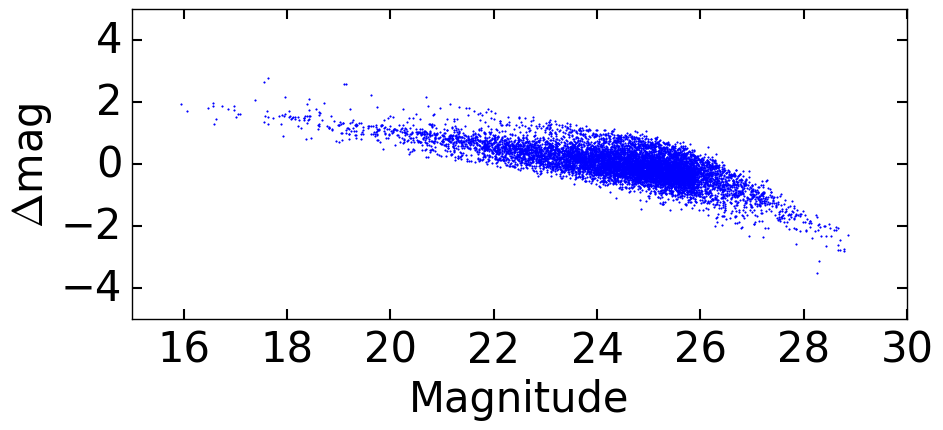

In [12]:
# plot magnitude-dmag trend
figure(figsize=(10,4))
plot(mag_d[sel][csel][mask_d[sel][csel]==False],mdev,'.',markersize=2)
xlim([15,30])
ylim([-5,5])
xlabel('Magnitude')
ylabel('$\Delta$mag')

There is a clear trend with magnitude, where brighter objects have their magnitudes overestimated (i.e. thought to be fainter), and fainter objects underestimated (i.e. thought to be brighter). This explains our previously observed trend, since underestimation shouldn't be a huge problem for the majority of objects in our sample at faint magnitude (since these are Luptitudes, the scale becomes approximately linear around $\sim 26$ mag where errors are already large), but overestimation is more serious at brighter magnitudes where the measured errors are smaller. This isn't necessarily what we want.

## WINBET: Weighted Inference with Naive Bayes and Extra Trees

To correct for some of the effects shown above, we need to take both of these factors into account. We accomplish this in four steps:

1. Impute missing data according to a **Naive Bayes** prior constructed from the marginal distribution in each band.
2. Find a set of neighbors without explicitly relying on distances using random embedded mappings created by **Extra Trees**.
3. Conduct targeted **inference** on those neighbors to derive a set of **likelihood weights**.
4. Estimate the photometry and variance using weights among all objects with non-missing values.

**WINBET** is implemented as a subroutine in FRANKEN-Z.

In [14]:
winbet=fz.WINBET() # intialize WINBET (Ntrees=100,Nleaf=10)
winbet.train(phot_train_d,var_train_d,mask_train_d,mag_train_d,magerr_train_d,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

There are two imputation modes in WINBET: **'random'** (a likelihood-weighted random draw from nearby objects) and **'mean'** (compute photometry and errors using weighted means/variances). Let's try using the 'mean' predictions first.

### Mean-based predictions

In [15]:
p1,v1=winbet.impute(phot_train_d,var_train_d,mask_train_d,'mean')

0 500 1000 1500 2000 2500 3000 

Since it's easier to compare logarithmic performance, we convert our results back to magnitudes.

In [21]:
mcensor,mecensor=fz.asinh_mag_map(p1,sqrt(var_train_d),skynoise,zeropoint=flux_zeropoint)
mcensor,mecensor2=fz.asinh_mag_map(p1,sqrt(v1),skynoise,zeropoint=flux_zeropoint)
dev=(mcensor-mag_train_d)[mask_train_d==False] # deviations
dev_norm=dev/(mecensor[mask_train_d==False]) # normalized deviations (imputed error norm)
dev_norm2=dev/(mecensor2[mask_train_d==False]) # normalized deviations (measured error norm)

mdev_mc=normal(zeros(len(dev)),magerr_train_d[mask_train_d==False]) # monte carlo
mdev_mc_norm=mdev_mc/magerr_train_d[mask_train_d==False] # normalized deviations (MC norm)

Median offset (imputed): -0.0347364435959
Median offset (Monte Carlo): 0.00171866002859


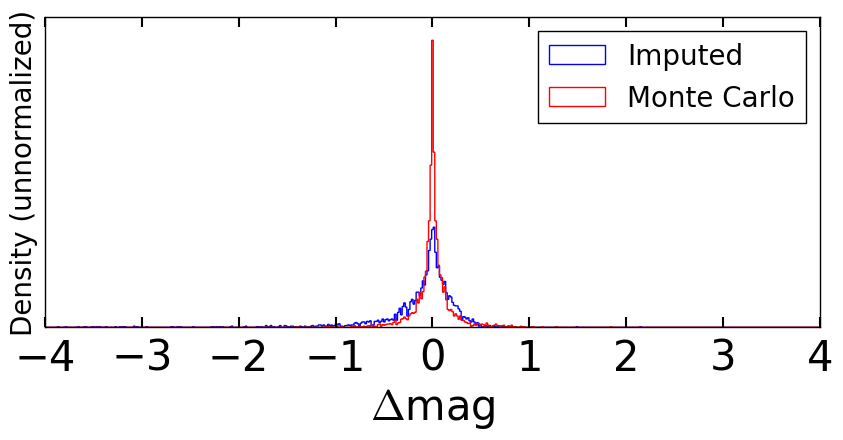

In [22]:
# plot mean deviation
figure(figsize=(10,4))
h=hist(dev,histtype='step',bins=linspace(-4,4,500),color='blue',label='Imputed',normed=True)
h=hist(mdev_mc,histtype='step',bins=linspace(-4,4,500),color='red',label='Monte Carlo',normed=True)
legend(fontsize=20)
xlabel('$\Delta$mag')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median offset (imputed):',median(dev)
print 'Median offset (Monte Carlo):',median(mdev_mc)

This looks pretty good -- the overall spread is much smaller, and the estimates are not heavily biased.

Median normalized offset (imputed): -0.570352060994
Median normalized offset (Monte Carlo): 0.0496019510283


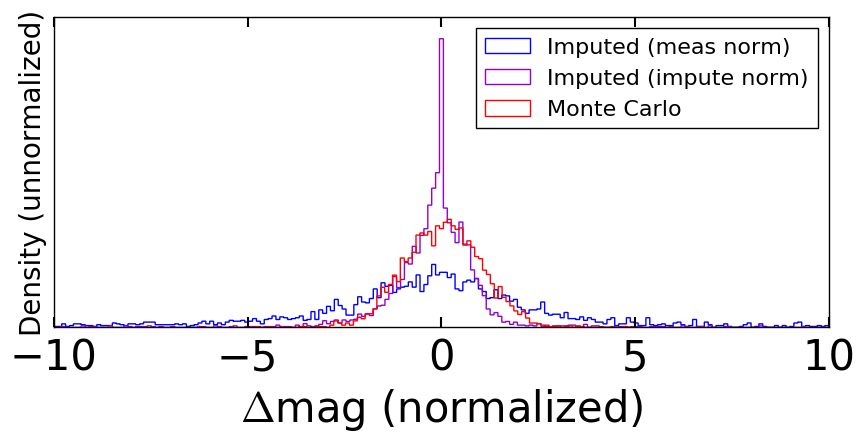

In [23]:
# plot mean normalized deviation
figure(figsize=(10,4))
h=hist(dev_norm,histtype='step',bins=linspace(-10,10,200),color='blue',label='Imputed (meas norm)',normed=True)
h=hist(dev_norm2,histtype='step',bins=linspace(-10,10,200),color='darkviolet',label='Imputed (impute norm)',normed=True)
h=hist(mdev_mc_norm,histtype='step',bins=linspace(-5,5,100),color='red',label='Monte Carlo',normed=True)
legend(fontsize=16)
xlabel('$\Delta$mag (normalized)')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median normalized offset (imputed):',median(dev_norm)
print 'Median normalized offset (Monte Carlo):',median(mdev_mc_norm)

Our normalized error distribution also resembles the expected (Monte Carlo) distribution once we normalize by the estimated impute errors rather than the actual measurement errors, although with somewhat broader tails. We do notice, however, a large proportion of objects with hugely inflated errors. That population will become clearer after the next few plots.

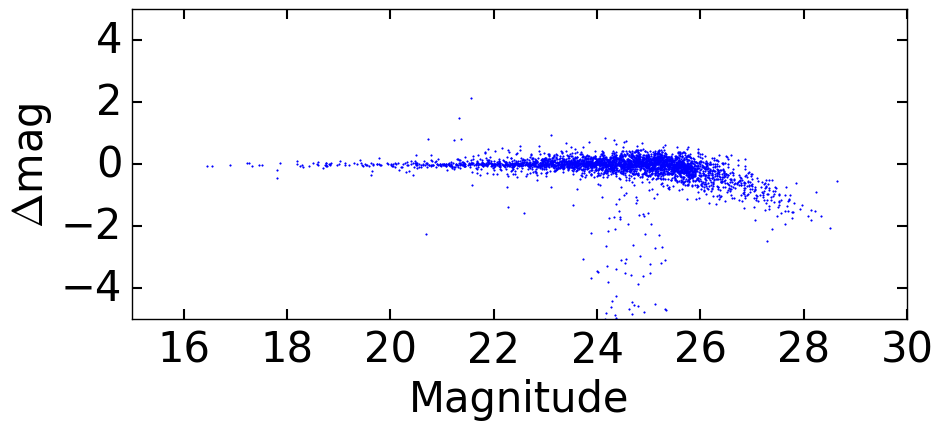

In [24]:
# plot magnitude-dmag trend
figure(figsize=(10,4))
plot(mag_train_d[mask_train_d==False],dev,'.',markersize=2)
xlim([15,30])
ylim([-5,5])
xlabel('Magnitude')
ylabel('$\Delta$mag')

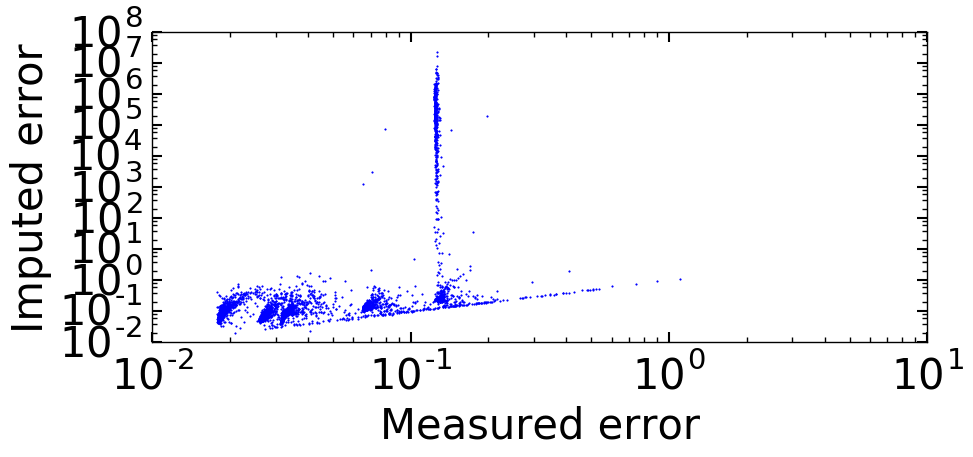

In [25]:
# plot measured ("true") vs imputed ("estimated") errors.
figure(figsize=(10,4))
loglog(sqrt(var_train_d)[mask_train_d==False],sqrt(v1)[mask_train_d==False],'.',markersize=2)
xlabel('Measured error')
ylabel('Imputed error')

In general, we can confirm that *not only* do we do a much better job overall of computing the magnitudes compared to FancyImpute, the trend with magnitude is noticeably improved: most of the imputed photometry at higher magnitudes now follows a smooth one-to-one relation. While at lower mags near the sky background limit there is a clear downward trend (overestimation), in general this bias is small compared to the sky background. 

As for that sub-population with huge errors? We notice that the broad tail of errors see in the above plot indicates we have hit a degeneracy between faint fluxes and bright fluxes. This is likely a manifestation of the well-known high-/low-$z$ degeneracy, where galaxies with similar looking colors in 4 bands ($rizy$) can have wildly different colors in the 5th ($g$). Since photometry is logarithmic, this bimodality manifests as an enormous variance, leading to huge errors.

### Random-based predictions

Since the imputed distribution might be non-Gaussian with widely-separated modes and/or subject to strong covariances (and thus might not be well modeled by the Gaussian mean/variance approximation), WINBET's 'random' estimates can be used to sample from this distribution "on-the-fly". We demonstrate this below by drawing 20 samples from the underlying distribution.

In [26]:
N_mc=20
runs=[winbet.impute(phot_train_d,var_train_d,mask_train_d,impute_type='random') for i in xrange(N_mc)]

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 

In [27]:
mcensors=[fz.asinh_mag_map(runs[i][0],sqrt(var_train_d),skynoise,zeropoint=flux_zeropoint) for i in xrange(N_mc)]
mcensors2=[fz.asinh_mag_map(runs[i][0],sqrt(runs[i][1]),skynoise,zeropoint=flux_zeropoint) for i in xrange(N_mc)]
dev=array([(mcensors[i][0]-mag_train_d)[mask_train_d==False] for i in xrange(N_mc)])
dev_norm=array([dev[i]/(mcensors[i][1][mask_train_d==False]) for i in xrange(N_mc)])
dev_norm2=array([dev[i]/(mcensors2[i][1][mask_train_d==False]) for i in xrange(N_mc)])

Let's now examine how well we do.

Median offset (imputed): -0.00958414701195
Median offset (Monte Carlo): 0.00171866002859


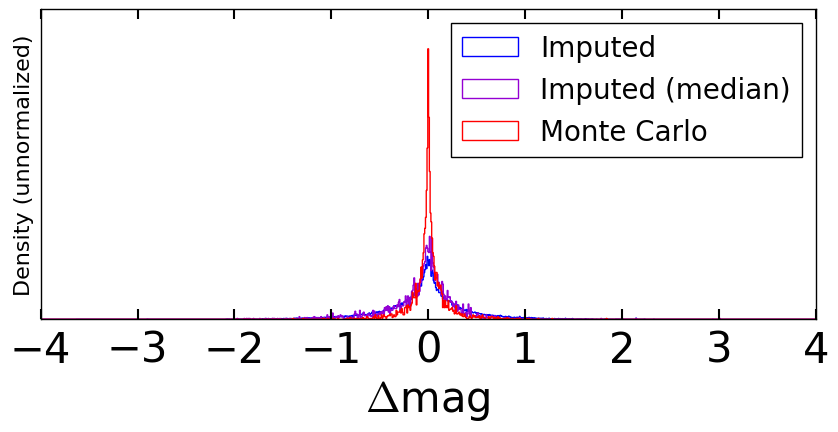

In [28]:
# plot mean deviation
figure(figsize=(10,4))
h=hist(dev.flatten(),histtype='step',bins=linspace(-4,4,1000),color='blue',label='Imputed',normed=True)
h=hist(median(dev,axis=0),histtype='step',bins=linspace(-4,4,1000),color='darkviolet',label='Imputed (median)',normed=True)
h=hist(mdev_mc,histtype='step',bins=linspace(-4,4,1000),color='red',label='Monte Carlo',normed=True)
legend(fontsize=20)
xlabel('$\Delta$mag')
ylabel('Density (unnormalized)',fontsize=16)
yticks([])

print 'Median offset (imputed):',median(dev.flatten())
print 'Median offset (Monte Carlo):',median(mdev_mc)

As with the 'mean' predictors, we notice that the general distribution of random samples is broader, which is what we'd expect given we're working with less information. We also notice that the median predictors do a better job of tracing the true distribution, indicating that while we are observing some amount of random variation due to measurement error, averaging over that information gives us a more accurate (hopefully unbiased) predictor of the true result.

Median normalized offset (meas norm): -0.158206232501
Median normalized offset (impute norm): -0.158334239226
Median normalized offset (median): -0.148705387796
Median normalized offset (Monte Carlo): 0.0496019510283


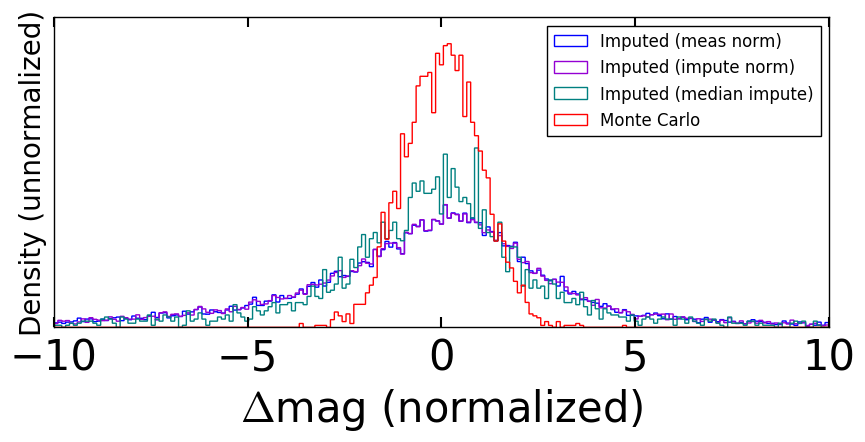

In [29]:
# plot mean normalized deviation
figure(figsize=(10,4))
h=hist(dev_norm.flatten(),histtype='step',bins=linspace(-10,10,200),color='blue',label='Imputed (meas norm)',normed=True)
h=hist(dev_norm2.flatten(),histtype='step',bins=linspace(-10,10,200),color='darkviolet',
       label='Imputed (impute norm)',normed=True)
h=hist(median(dev_norm2,axis=0),histtype='step',bins=linspace(-10,10,200),color='teal',
       label='Imputed (median impute)',normed=True)
h=hist(mdev_mc_norm,histtype='step',bins=linspace(-10,10,200),color='red',label='Monte Carlo',normed=True)
legend(fontsize=12)
xlabel('$\Delta$mag (normalized)')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median normalized offset (meas norm):',median(dev_norm)
print 'Median normalized offset (impute norm):',median(dev_norm2)
print 'Median normalized offset (median):',median(median(dev_norm2,axis=0))
print 'Median normalized offset (Monte Carlo):',median(mdev_mc_norm)

Normalizing by the observed/imputed errors, we notice that the errors sampled by our random draws are underestimated. Unlike the mean case, this is exactly what we'd expect. For each realization, we are sampling a random object's flux and flux errors, so this indicates the true variation spanned by the distribution is larger than that spanned by the measurement error of each draw. 

Also as expected, the median deviation across draws is narrower, mirroring our first plot. This is illustrated below.

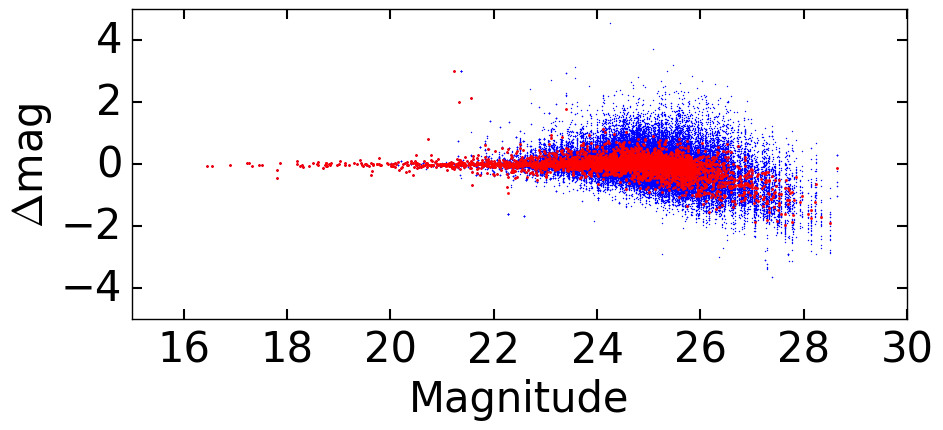

In [30]:
# plot magnitude-dmag trend
figure(figsize=(10,4))
[plot(mag_train_d[mask_train_d==False],dev[i],'b.',markersize=1) for i in xrange(20)]
plot(mag_train_d[mask_train_d==False],median(dev,axis=0),'r.',markersize=3)
xlim([15,30])
ylim([-5,5])
xlabel('Magnitude')
ylabel('$\Delta$mag')

The behavior of our 'random' imputed quantities as a function of magnitude is very similar to our 'mean' predictions, which is always good to confirm. Finally, we can again take a look at the predicted vs. actual errors.

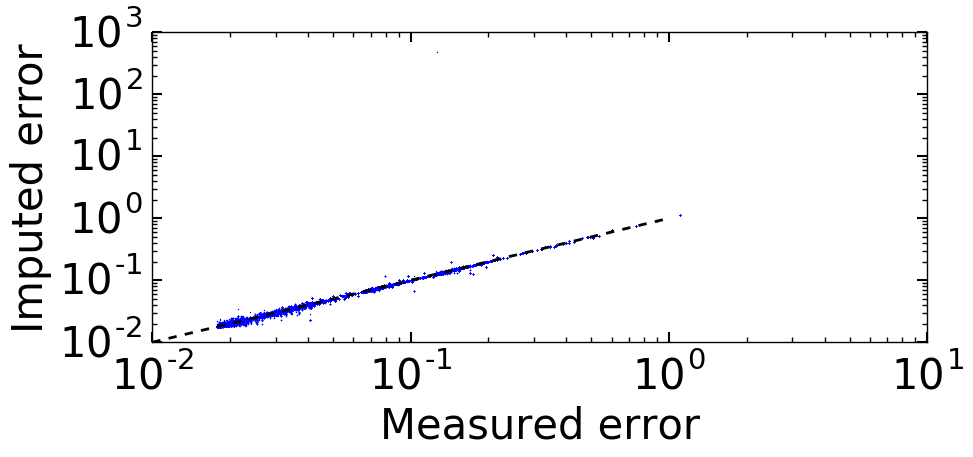

In [31]:
# plot measured ("true") vs imputed ("estimated") errors.
figure(figsize=(10,4))
[loglog(sqrt(var_train_d)[mask_train_d==False],sqrt(runs[i][1])[mask_train_d==False],'b.',markersize=1) for i in xrange(20)]
plot([1e-2,1e0],[1e-2,1e0],'k--',lw=2)
xlabel('Measured error')
ylabel('Imputed error')

This at first appears counterintuitive: **for a given realization**, we actually appear to be in the same error regime as the original observation. But we showed that our imputed variation is significantly larger than expected from measurement error. So what gives?

This is another way of visualizing that the population variance at a given magnitude (i.e. at a given depth) is larger than the formal measurement error. Or to put it another way, **there's a broader range of SEDs permitted at a given (unknown) magnitude than the formal measurement error for any individual SED given constrained by the other magnitudes**. We also see a few isolated draws of largely-discrepant errors, confirming the broad swath of mean fits were caused in part by objects with small (but non-zero) weights located at these degeneracies.

## Implementation with FRANKEN-Z

We've done most of the heavy-lifting at this point, so all that's left to do is decide how to account for differences in log-likelihoods across varying numbers of bands. We take advantage of the fact that for normally distributed data, the sum of squares is distributed according to a $\chi^2_n$ distribution with $n$ degrees of freedom. This has an expectation value of $n$, and so a band-invariant quantity with an expectation value of $0$ can be constructed via

\begin{equation}
\chi^2_{\textrm{mod}}(h,g) = \chi^2(h,g)-N_{\textrm{bands}}(h,g),
\end{equation}

where $\chi^2(h,g)$ is the standard $\chi^2$ statistic between $h$ and $g$ from the previous notebook computed using $N_{\textrm{bands}}(h,g)$ overlapping bands between $h$ and $g$.

In [27]:
# initialize FRANKEN-Z instance
frankenz=fz.FRANKENZ(N_members=25)

In [28]:
# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(phot_train_d,var_train_d,mask_train_d,mag_train_d,magerr_train_d,mdict)
winbet_test.train(phot_test_d,var_test_d,mask_test_d,mag_test_d,magerr_test_d,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

We'll demonstrate two ways to impute data: pre-filling the arrays using mean-generated data, and generating data "on the fly" by passing the WINBET classes to FRANKEN-Z directly.

Let's do mean-generated data first.

In [29]:
# compute mean quantities
p1,v1=winbet_train.impute(phot_train_d,var_train_d,mask_train_d,impute_type='mean')
p2,v2=winbet_test.impute(phot_test_d,var_test_d,mask_test_d,impute_type='mean')

0 500 1000 1500 2000 2500 0 500 1000 1500 2000 2500 3000 3500 4000 

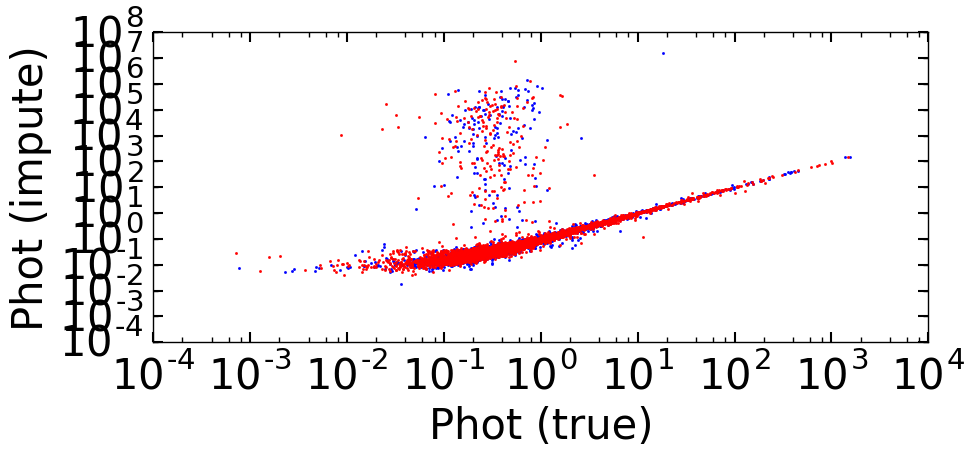

In [30]:
# plot photometric reconstruction
figure(figsize=(10,4))
loglog(phot_train_d[mask_train_d==False],p1[mask_train_d==False],'b.',markersize=3)
loglog(phot_test_d[mask_test_d==False],p2[mask_test_d==False],'r.',markersize=3)
xlabel('Phot (true)')
ylabel('Phot (impute)')

In [11]:
# compute quantities
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,sqrt(v1),mask_train_d,p2,sqrt(v2),mask_test_d)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


In [12]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum()/Nm)+model_llmin[i] # -2ln(Evidence), normalized to number of objects used in fit
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


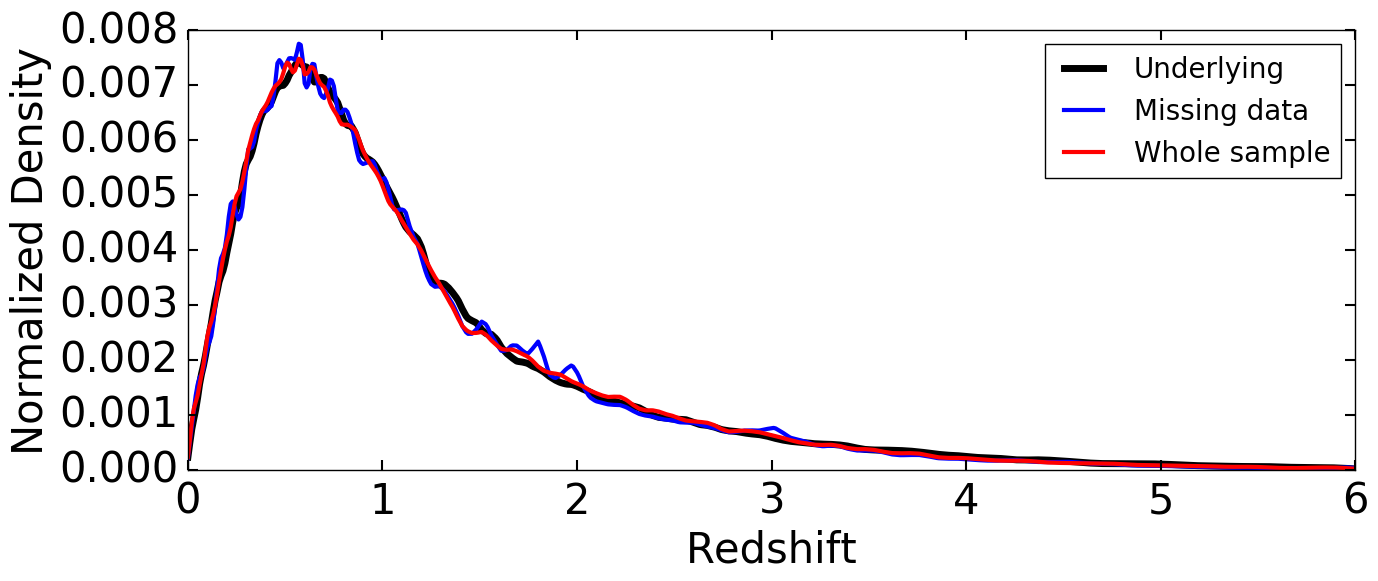

In [13]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf_fz[csel[test_sel]],axis=0)/sum(csel[test_sel]),lw=3,color='blue',label='Missing data')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=3,color='red',label='Whole sample')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


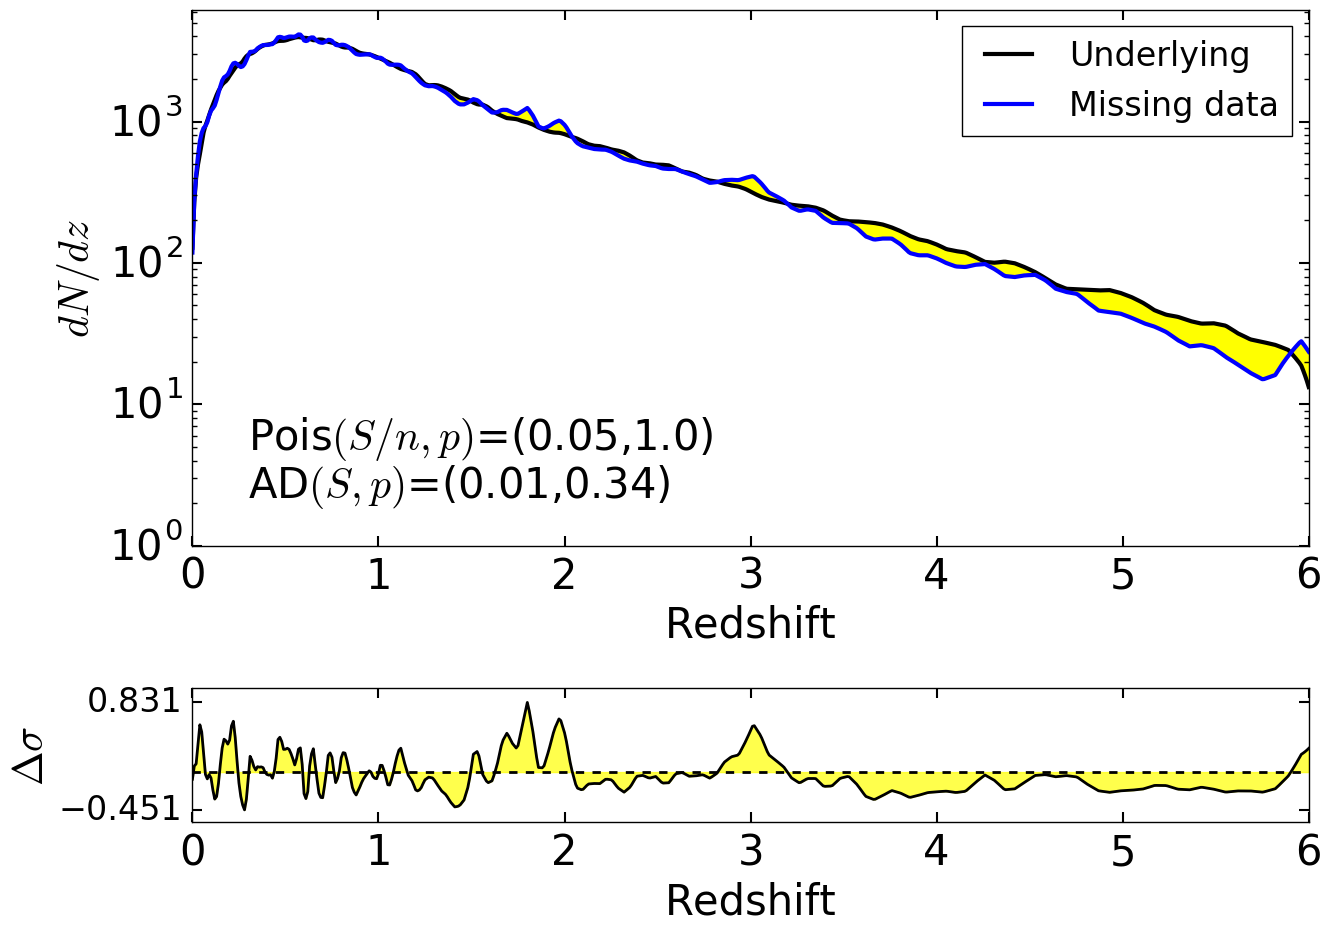

In [14]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*sum(csel[test_sel]),nansum(zpdf_fz[csel[test_sel]],axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Missing data'],colors=['black','blue'])

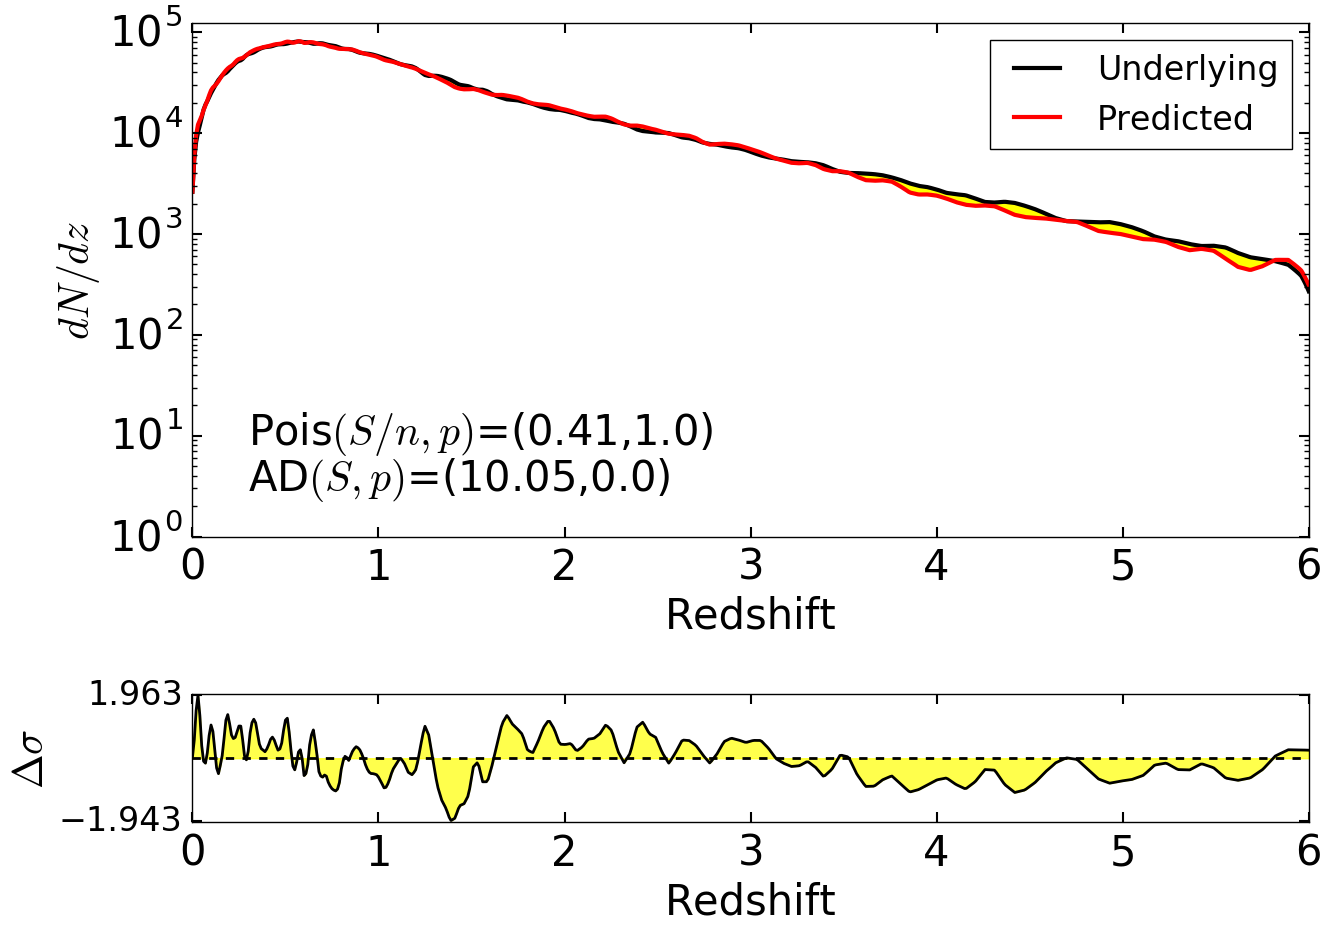

In [15]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,nansum(zpdf_fz,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Predicted'],colors=['black','red'])

That looks pretty good! Let's now try the on-the-fly predictions. This obviously is $N_{MC}$ times slower than just generating a set of predictions once, but should allow us to better model imputed object flux/error covariances.

In [16]:
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,sqrt(v1),mask_train_d,p2,sqrt(v2),mask_test_d,
                                                            impute_train=winbet_train,impute_test=winbet_test)

0 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 1 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 2 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 3 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 4 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 6 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 7 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 8 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 9 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 10 0 500 1000 1500 2000 2500 3000 3500 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 11 0 500 1000 1500 2

In [17]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum()/Nm)+model_llmin[i] # -2ln(Evidence), normalized to number of objects used in fit
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


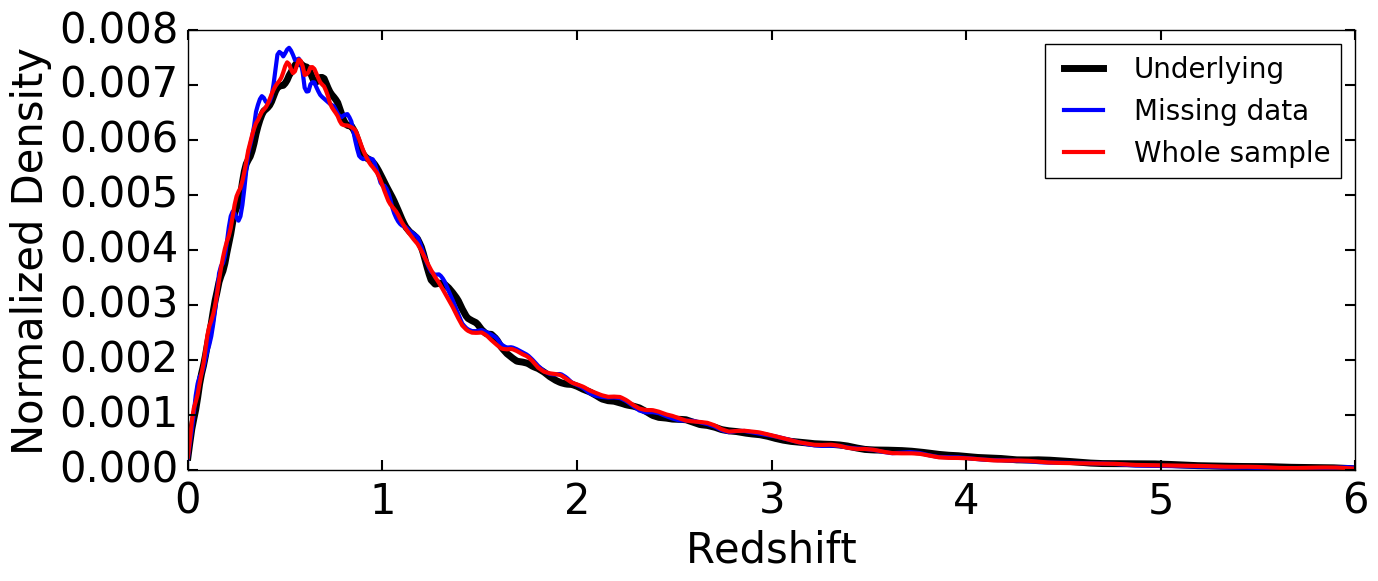

In [18]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf_fz[csel[test_sel]],axis=0)/sum(csel[test_sel]),lw=3,color='blue',label='Missing data')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=3,color='red',label='Whole sample')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

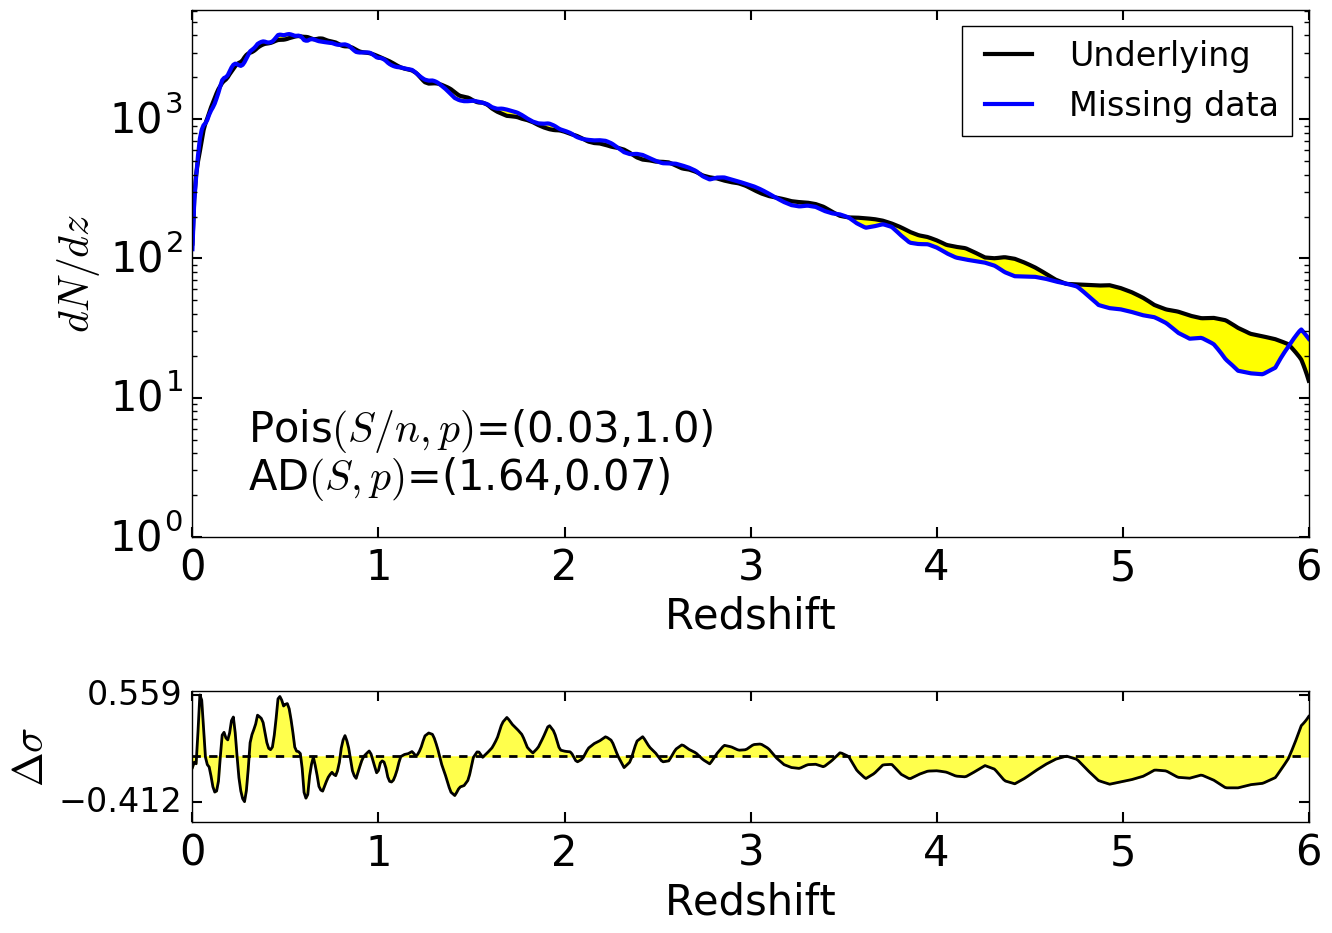

In [19]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*sum(csel[test_sel]),nansum(zpdf_fz[csel[test_sel]],axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Missing data'],colors=['black','blue'])

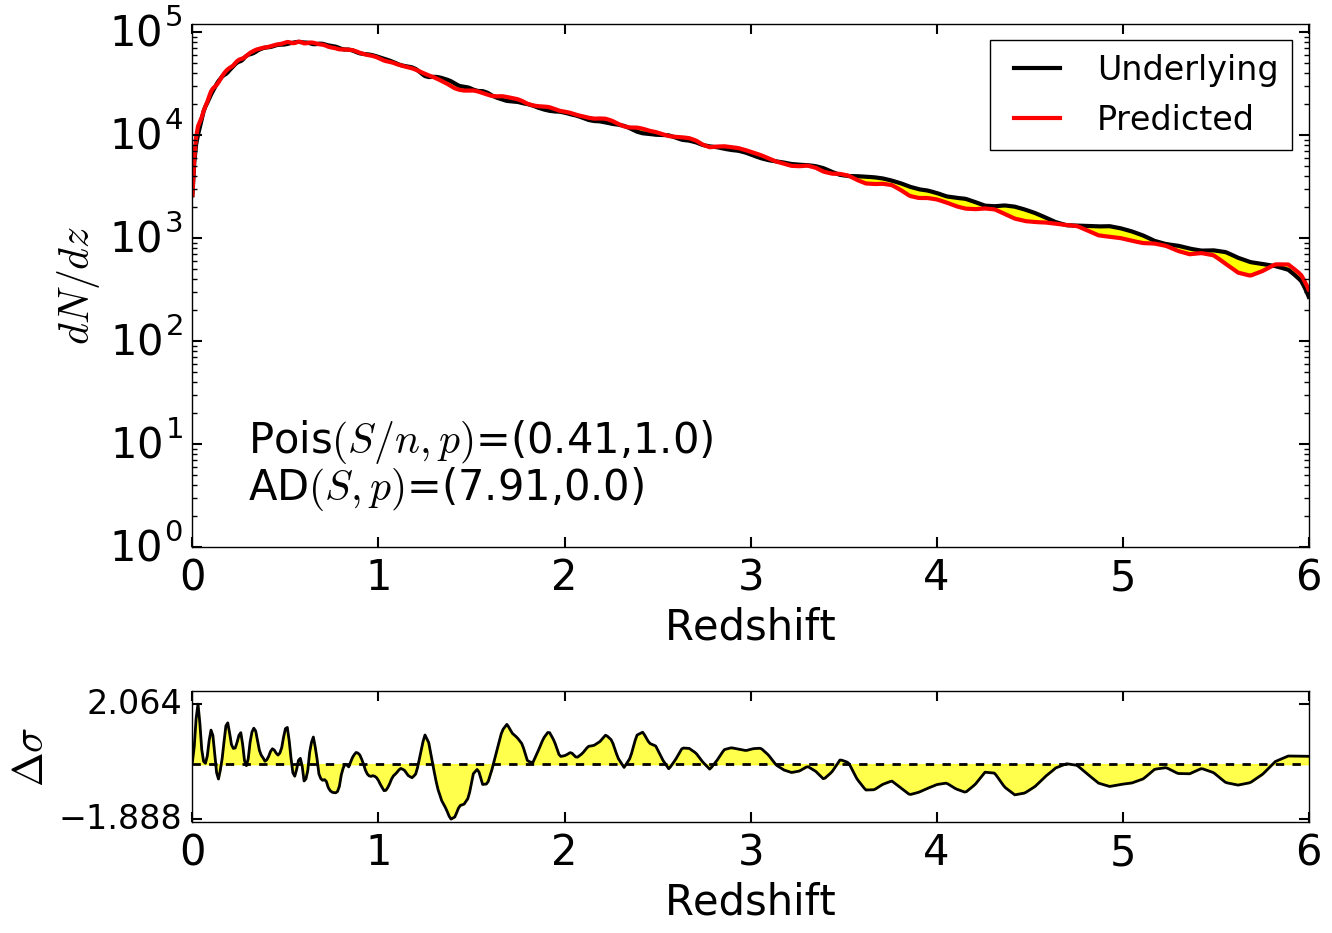

In [20]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,nansum(zpdf_fz,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Predicted'],colors=['black','red'])

Both look quite comparable.

## Hierarchical Modeling

The final step is to make sure our modified likelihoods work within a Hierarchical Bayesian context. We first check that our selection-modified likelihoods behave well.

In [31]:
# establish flux cut
flux_cut=zeros(Nf)-inf
flux_cut[2]=fz.inv_asinh_mag_map(array([maglims]),array([ones(Nf)*0.2]),skynoise,zeropoint=flux_zeropoint)[0][0][2]

In [34]:
# selection probability
phot_test_d_lsel=-2*sum(log(1-0.5*special.erfc((phot_test_d-flux_cut)/(sqrt(2*var_test_d)))),axis=1)

In [35]:
model_lsel=copy(model_ll) # selection-modified likelihood
Nmc=100

# compute corrections
for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx=model_obj[i][:Nm]
    xmu=phot_train_d[midx]
    xvar=var_train_d[midx]+var_test_d[i]
    samples=normal(xmu,sqrt(xvar),size=(Nmc,Nm,Nf)) # Monte Carlo draws
    x=(samples-flux_cut)/sqrt(2*var_test_d[i]) 
    model_lsel[i][:Nm]=-2*sum(log(1-special.erfc(x).sum(axis=0)/(2*Nmc)),axis=1)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 

In [36]:
# generate redshifts
model_llmin_sel=empty(Ntest).astype(float)
lzpdf_sel=empty((Ntest,rdict.Nz))
zpdf_fz_sel=empty((Ntest,Nz))
levidence_fz_sel=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    lpsel=phot_test_d_lsel[i]
    Nm=model_Nobj[i]
    midx,ll,lsel=model_obj[i][:Nm],model_ll[i][:Nm],model_lsel[i][:Nm]
    llsel=(ll+lpsel-lsel) # selection-effect corrected probability
    model_llmin_sel[i]=llsel.min() # minimum value (for scaling)
    weights=exp(-0.5*(llsel-model_llmin_sel[i])) # transform to scaled likelihood weights
    levidence_fz_sel[i]=-2*log(weights.sum())+model_llmin_sel[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf_sel[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz_sel=fz.pdfs_resample(rdict.zgrid,lzpdf_sel/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


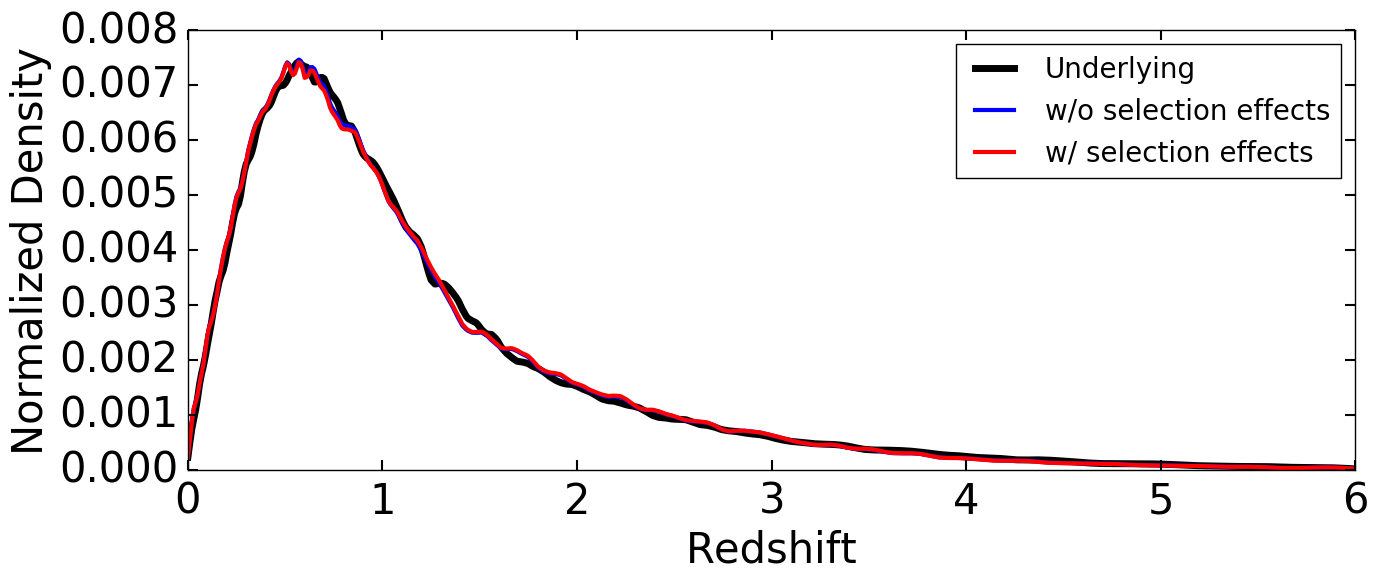

In [37]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# original
pz=nansum(zpdf_fz,axis=0)/Ntest
plot(rdict.zgrid_out,pz,lw=3,color='blue',label='w/o selection effects')

# new
pz=nansum(zpdf_fz_sel,axis=0)/Ntest
plot(rdict.zgrid_out,pz,lw=3,color='red',label='w/ selection effects')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

That looks fine, so onto the hierarchical modeling!

In [38]:
p_fh=ones(Ntrain)/Ntrain # uniform prior

In [39]:
fh=zeros(Ntrain)

for i in xrange(Ntest):
    Nm=model_Nobj[i]
    lpsel=phot_test_d_lsel[i]
    midx,ll,lsel,llminsel=model_obj[i][:Nm],model_ll[i][:Nm],model_lsel[i][:Nm],model_llmin_sel[i]
    llsel=(ll+lpsel-lsel)
    weights=exp(-0.5*(llsel-llminsel))
    weights*=p_fh[midx] # multiply by global prior
    fh[midx]+=weights/weights.sum() # stack

In [40]:
N_samples=100
fh_t=zeros((N_samples,len(fh)))

# Gibbs sampler
fh_t[0]=fh # initialize

for i in xrange(N_samples-1):
    sys.stdout.write(str(i)+' ')
    fh_i=random.dirichlet(fh_t[i]+1) # draw population
    for j in xrange(Ntest):
        Nm=model_Nobj[j] # number of models
        lpsel=phot_test_d_lsel[j]
        midx,ll,lsel,llminsel=model_obj[j][:Nm],model_ll[j][:Nm],model_lsel[j][:Nm],model_llmin_sel[j]
        llsel=(ll+lpsel-lsel)
        weights=exp(-0.5*(llsel-llminsel))
        weights*=fh_i[midx]*p_fh[midx] # (P(pop_global)*P(pop_conditional)*likelihood)
        fh_t[i+1][midx]+=weights/weights.sum()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

In [41]:
N_burnin=20 # burn-in trials
z_pdf_draws=empty((N_samples-N_burnin,rdict.Nz_out)) # dn/dz draws

for i in xrange(N_burnin,N_samples):
    sys.stdout.write(str(i)+' ')
    midx=choice(Ntrain,p=fh_t[i]/fh_t[i].sum(),size=Ntest) # sample from f^h
    temp1,temp2=lzidx_train_d[midx],lzeidx_train_d[midx]
    pz=zeros(rdict.lzgrid_highres.shape)
    for j in xrange(Ntest):
        t1,t2=temp1[j],temp2[j]
        w,k=rdict.sig_width[t2],rdict.sig_dict[t2]
        pz[choice(xrange(t1-w,t1+w+1),p=k/k.sum())]+=1
    pz=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    pz=interp(rdict.zgrid_out,rdict.zgrid,pz)
    pz/=pz.sum()
    z_pdf_draws[i-N_burnin]=pz
z_pdf_draws_mean=z_pdf_draws.mean(axis=0)
z_pdf_draws_mean/=z_pdf_draws_mean.sum()

20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

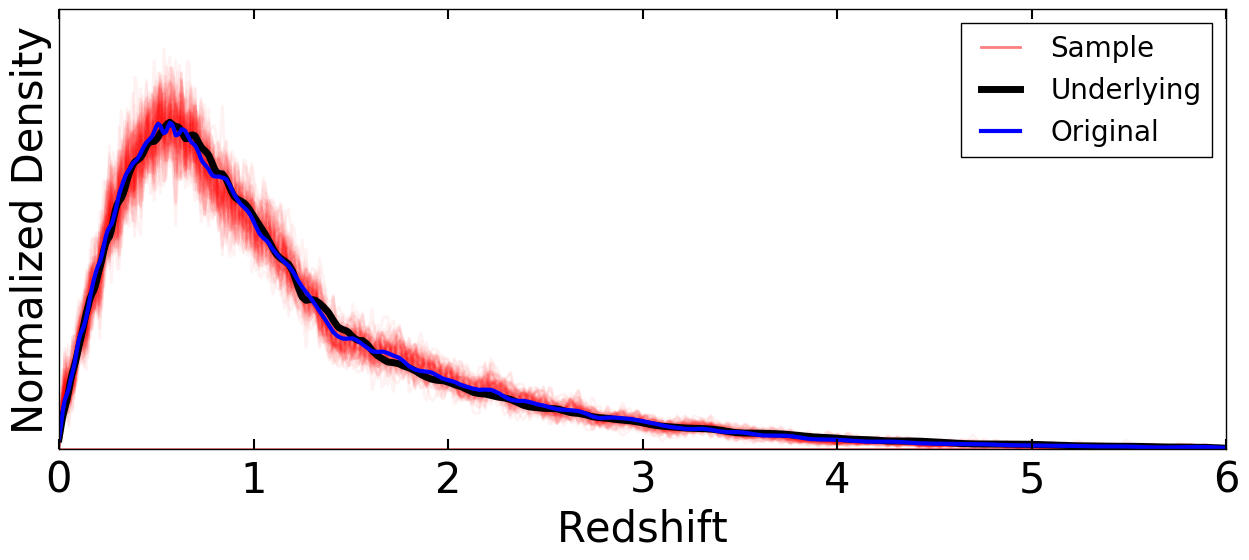

In [42]:
figure(figsize=(14,6))

#plot(rdict.zgrid_out,z_pdf_draws_mean,lw=5,color='black',alpha=0.5,label='Mean')
plot(rdict.zgrid_out,zeros(rdict.Nz_out),lw=2,color='red',alpha=0.5,label='Sample')
[plot(rdict.zgrid_out,z_pdf_draws[i],lw=2,color='red',alpha=0.05) for i in xrange(N_samples-N_burnin)]
#plot(rdict.zgrid_out,z_pdf_draws_mean,lw=5,color='black',alpha=0.5)

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# original result
plot(rdict.zgrid_out,nansum(zpdf_fz_sel,axis=0)/Ntest,lw=3,color='blue',label='Original')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
tight_layout()
legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('Normalized Density')

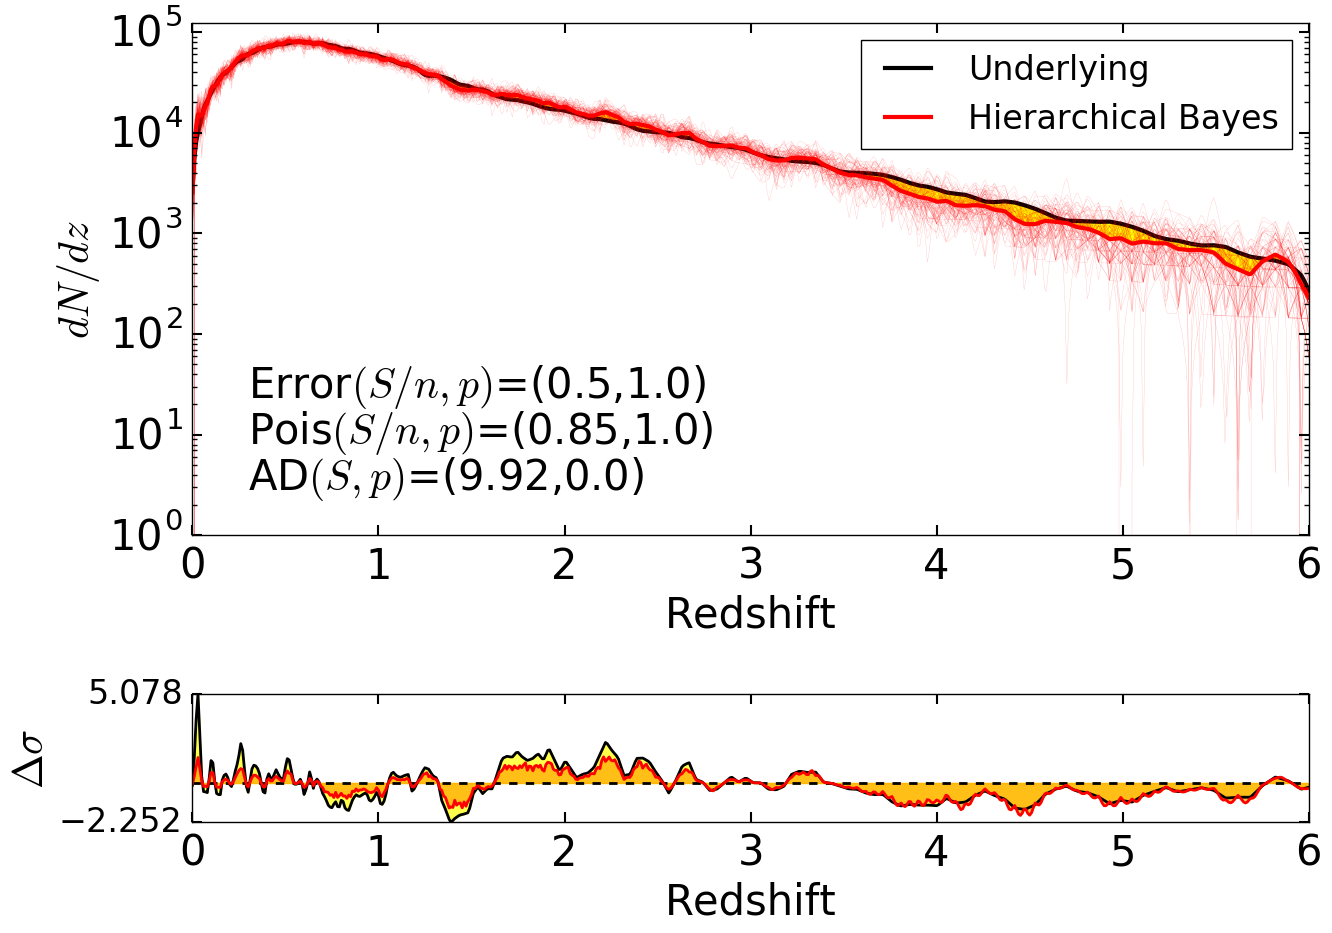

In [43]:
figure(figsize=(14,10))
Q_pois,Q_ad,Q_err=fz.plot_nz(z_pdf*Ntest,z_pdf_draws_mean*Ntest,rdict.zgrid_out,rdict.dz_out,out_nz_draws=z_pdf_draws*Ntest,
                             sample_names=['Underlying','Hierarchical Bayes'],colors=['black','red'])

The well-behaved nature of our output $dN/dz$ draws demonstrates that our $N_{\textrm{bands}}$-invariant log-likelihood successfully accounts for missing data when modeling the true distribution in an unbiased way.